In [63]:
import os
import torch
from torchvision import models
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

from PIL import Image

from IPython import display
from IPython.display import Image as display_image
from matplotlib import pyplot as plt

%matplotlib inline

### Get the data
For this tutorial we used the 30k Flickr dataset, that you can download from:

https://www.kaggle.com/hsankesara/flickr-image-dataset/data

but any directory with images will work just as well. For more than 300,000 files you will need to start optimizing for efficiency.

In [84]:
IMAGE_DIR = '~/DATA/flickr30k_images/flickr30k_images/'

def get_image_paths(data_dir):
    # https://www.kaggle.com/hsankesara/flickr-image-dataset/data
    query = os.path.join(data_dir, '*jpg')
    paths = glob(query)
    return paths

image_paths = get_image_paths(os.path.expanduser(IMAGE_DIR))
print(f'Got {len(image_paths)} images')

Got 31783 images


### Feature extractor
This is the inference part of a ResNet backbone without the final layer.

In [65]:
class ResNetFeatures:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.scale = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.to_tensor = transforms.ToTensor()
        self.transform = transforms.Compose([
            self.scale,
            self.to_tensor,
            self.normalize
        ])
        
    def get_features(self, image):
        # This is common for all the resnets:
        # https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L201
        x = self.transform(image)
        x = x.unsqueeze(0)
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        # This is the [:-2] layer - final layer of features before classification
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        vector = x.detach().numpy()[0]
        
        # Normalize
        vector = vector / np.sqrt(np.power(vector, 2).sum())

        return vector

### Data processing
For every image we use the __ResNetFeatures__ to get the last layer activations/features and store it in a DataFrame. Stash the results in the `tmp/` directory, use the `forece=True` argument to recalculate. This isn't a particularly fast procedure - can take almost 2 hours on your laptop.

In [70]:
def make_dataset(image_paths, force=False):
    savepath = 'tmp/dataset.pickle'
    if os.path.exists(savepath) and not force:
        df = pd.read_pickle(savepath)
        return df
    model = models.resnet.resnet50(pretrained=True)
    extractor = ResNetFeatures(model)

    scores = []
    for path in tqdm(image_paths):
        img = Image.open(path)
        vector = extractor.get_features(img)
        score = {
            'path': path,
            'features': vector
        }
        scores.append(score)

    df = pd.DataFrame(scores)
    df.to_pickle(savepath)
    return df

In [71]:
df = make_dataset(IMAGE_DIR, force=True)

100%|██████████| 31783/31783 [1:44:30<00:00,  5.07it/s]  


### Calculate similarities
The `scores` object here is a similarity matrix where $scores_{ij}$ is the similarity value between i-th and j-th image.

In [72]:
all_features = np.vstack(df.features.values)

# Cosine distance is equal to dot-produc
scores = all_features @ all_features.T

### Explore results
Choose one of the image from

In [76]:
jumping_doge_id = 4368
dancer_lady_id = 1151
score = scores[jumping_doge_id]

# Sort starting from the most similar
ids = np.argsort(score)[::-1]

display_image()

4368 1.0


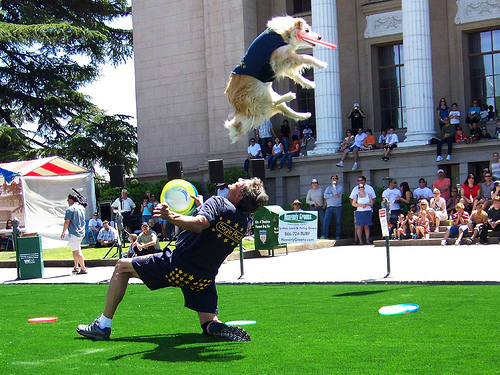

5703 0.84101236


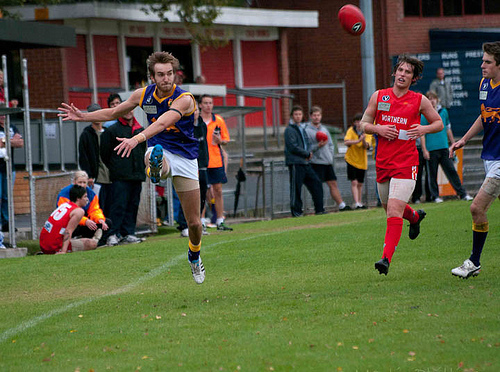

11596 0.83894944


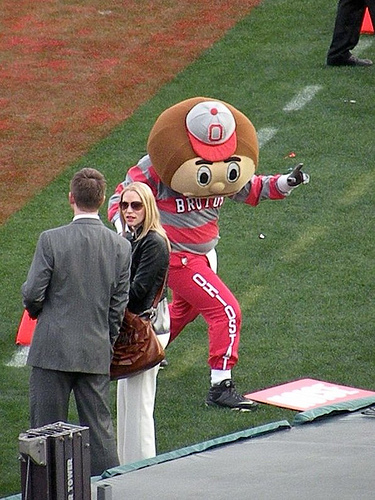

14010 0.83865625


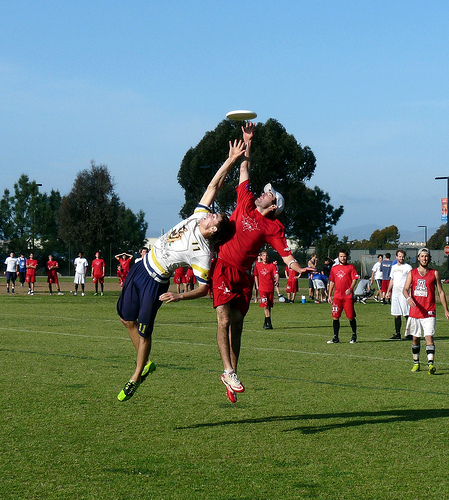

29576 0.83775777


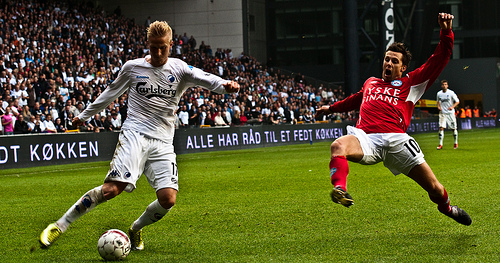

In [79]:
for it in ids[:5]:
    print(it, score[it])
    img = display_image(df.iloc[it].path, width=420)
    display.display(img)

### Visualizations

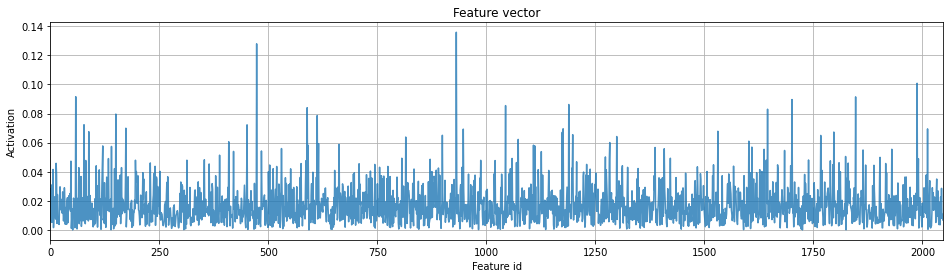

In [78]:
plt.figure(figsize=[16, 4])
for it in ids[:1]:
    plt.plot(df.iloc[it].features, alpha=0.8)
    plt.grid()
    plt.title('Feature vector')
    plt.ylabel('Activation')
    plt.xlabel('Feature id')
    plt.xlim(0, 2048)